# Learning Unit 2: Image Segmentation
The objective of this exercise is to guide you step-by-step through the implementation of a deep CNN for multi-label segmentation. We will be using the JSRT dataset with 160 training and 87 validation scans with 5 anatomical labels (heart, left/right lung, left/right collarbone).

First you will implement and train a standard fully-convolutional network that directly predicts the probability of each class on a coarse grid and uses a simple upsampling to match the original resolution. Second you will extend the network and implement a lightweight version of the popular U-Net architecture.

In [1]:
# for use in google colab
!pip install torchinfo
# imports
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
import torch
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchinfo import summary
from tqdm.notebook import tqdm, trange
import numpy as np

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# check if cuda is available
if (torch.cuda.is_available() == False):
    print('CUDA not found! It is highly recommended to enable CUDA for the exercises')
    device = 'cpu'
else:
    print('CUDA GPU found: ', torch.cuda.get_device_name(['0']))
    device = 'cuda'

CUDA GPU found:  Tesla T4


In [2]:
# download the data
!wget -nc https://cloud.imi.uni-luebeck.de/s/JkDxJnnDXCa7sy6/download -O jsrt_seg_masks.pth
!wget -nc https://cloud.imi.uni-luebeck.de/s/sBgNizxWk2boDXK/download -O JSRT_img0_lms.pth
# define the dataset
class JSRTDataset(Dataset):
    SPLIT_IDX = 160

    def __init__(self, mode: str, ):
        super().__init__()
        # load data
        data = torch.load('JSRT_img0_lms.pth', map_location='cpu')
        self.imgs = data['JSRT_img0'].float()  # already z-normalized
        del data
        self.seg_masks_onehot = torch.load('jsrt_seg_masks.pth').long() #long converts to all items in the array to an integer type

        # check for equal number of samples
        assert self.imgs.shape[0] == self.seg_masks_onehot.shape[0]
        N,C,H,W = self.seg_masks_onehot.shape
        self.seg_masks = torch.zeros(N,H,W).long()
        for channel in range(C):
            self.seg_masks[self.seg_masks_onehot[:,channel]==1]=channel+1

        # select images for training or testing
        if mode == 'train':
            self.imgs = self.imgs[:self.SPLIT_IDX]
            self.seg_masks = self.seg_masks[:self.SPLIT_IDX]
        elif mode == 'test':
            self.imgs = self.imgs[self.SPLIT_IDX:]
            self.seg_masks = self.seg_masks[self.SPLIT_IDX:]
        else:
            raise ValueError(f'Unknown mode {mode}')

    def __len__(self):
        return self.imgs.shape[0]

    def __getitem__(self, idx):
        img = self.imgs[idx].unsqueeze(0)
        seg_mask = self.seg_masks[idx]
        return img, seg_mask

# save train and validation datasets
train_dataset = JSRTDataset('train')
val_dataset = JSRTDataset('test')

--2024-04-22 18:14:44--  https://cloud.imi.uni-luebeck.de/s/JkDxJnnDXCa7sy6/download
Resolving cloud.imi.uni-luebeck.de (cloud.imi.uni-luebeck.de)... 141.83.20.118
Connecting to cloud.imi.uni-luebeck.de (cloud.imi.uni-luebeck.de)|141.83.20.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80938175 (77M) [application/octet-stream]
Saving to: ‘jsrt_seg_masks.pth’

jsrt_seg_masks.pth  100%[===================>]  77.19M  14.3MB/s    in 6.9s    

2024-04-22 18:14:52 (11.2 MB/s) - ‘jsrt_seg_masks.pth’ saved [80938175/80938175]

--2024-04-22 18:14:52--  https://cloud.imi.uni-luebeck.de/s/sBgNizxWk2boDXK/download
Resolving cloud.imi.uni-luebeck.de (cloud.imi.uni-luebeck.de)... 141.83.20.118
Connecting to cloud.imi.uni-luebeck.de (cloud.imi.uni-luebeck.de)|141.83.20.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32704316 (31M) [application/octet-stream]
Saving to: ‘JSRT_img0_lms.pth’

JSRT_img0_lms.pth   100%[===================>]  31.1

Let's visualise one example scan with its segmentation. Labels range from 0 to 5, with 1 to 5 corresponding to the labeled anatomical structures and 0 representing the background (i.e. all residual unlabeled parts) The images in the dataset are already normalised with a Z score normalization, so it has a mean of 0 and variance of 1.

Mean: 0.0 Variance: 1.0


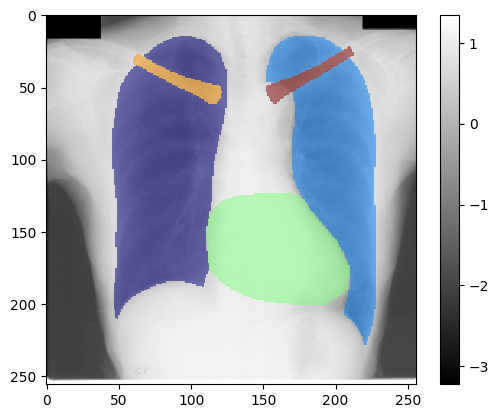

In [3]:
test_img, test_seg = val_dataset[2]
plt.imshow(test_img.squeeze(), cmap='gray')
plt.colorbar()
plt.imshow(np.ma.masked_where(test_seg.squeeze()==0, test_seg.squeeze()), alpha=0.5, interpolation='nearest', cmap='jet')
print('Mean: {:.1f} Variance: {:.1f}'.format(test_img.mean().item(), test_img.var().item()))

## Dice Score
To evaluate your segmentation model, implement a function to calculate the Dice Score Coefficient. The Dice is calculated as twice the number of pixels shared between prediction and ground truth divided by the sum of pixels in prediction and ground truth. Perfect overlap resutls in a Dice Score of 1, no overlap in a Dice Score of 0.

To avoid dividing by 0 when a label is not present, add a small offset (```1e-8```) to numerator and denominator. This does not change the result in a significant way for any values other than 0.

In [4]:
def dice_coeff(prediction, ground_truth, max_label):
    dice = torch.FloatTensor(max_label - 1).fill_(0)
    for label_num in range(1, max_label):
        # number of pixels in predicted segmentation
        iflat = (prediction == label_num).view(-1).float()
        # number of pixels in ground truth segmentation
        tflat = (ground_truth == label_num).view(-1).float()
        # number of pixels of the intersection of both segmentations
        intersection = torch.sum(iflat * tflat)
        denominator = torch.sum(iflat) + torch.sum(tflat)
        # TODO:
        epsilon = 1e-8
        dice[label_num - 1] = (2.0 * intersection + epsilon) / (denominator + epsilon)
    return dice

Test your implementation. This should return ```tensor([0.7778, 0.6857, 0.8266, 0.6770, 0.2093, 1.0000])```.

In [5]:
test_img2, test_seg2 = val_dataset[0]
dice_coeff(test_seg, test_seg2, max_label=7)

tensor([0.7778, 0.6857, 0.8266, 0.6770, 0.2093, 1.0000])

## Data augmentation
Due to the limited number of training data in our dataset and the resulting risk of overfitting during training, we want to create synthetic data by using small random affine transformations on the fly.

For this task, you can use `F.grid_sample`. `F.grid_sample` takes a grid (flow field) with world coordinates and samples the values from the input for the specified position. Read the [pytorch-doc](https://pytorch.org/docs/stable/generated/torch.nn.functional.grid_sample.html) for a detailed explanation.

Create a random transformation matrix `theta` of shape $[B,2,3]$, where $B$ describes the batch size. Create `theta` using `torch.eye` and add a random offset via `torch.randn` to it. The offset should be weighted with 0.1. To obtain the needed shape use broadcasting with `.unqueeze(0)` on the eye matrix.

Next, use `theta` to create a flow field with `F.affine_grid` with the image shape as target output size.

With the flow field you can then sample from image and ground truth using `F.grid_sample`. Take the data types (float for image, long for segmentation) into consideration. Use `mode=bilinear` for the image and `mode=nearest` for the ground truth.

The results should be have the shape $[B,1,256,256]$ with batch size , 1 channel, height 256 and width 256.

In [58]:
def augment_affine(image: torch.Tensor, ground_truth: torch.Tensor):
    batch_size = image.shape[0]
    # TODO: implement the affine transformation
    identity_matrix = torch.eye(2).unsqueeze(0).expand(batch_size, -1, -1) #Create a 2x2 identity matrix
    theta = torch.cat([identity_matrix, torch.zeros(batch_size, 2,1)], dim = 2) #Create theta, our transformation matrix by concatinating a further column to get 2x3
    random_offset = 0.1 * torch.randn(batch_size,2,3) #Create a random offset
    theta = torch.add(theta, random_offset) #Add offset to theta
    theta.to(image.device)
    grid = F.affine_grid(theta, image.size()).to(image.device)  #Create grid
    image = F.grid_sample(image, grid, mode = 'bilinear') #Create sample based on image
    ground_truth = F.grid_sample(ground_truth.unsqueeze(1).float(), grid, mode = 'nearest').long() #Create sample based on ground_truth
    # need to be fulfilled
    assert image.dtype == torch.float
    assert ground_truth.dtype == torch.long
    assert list(image.shape) == [batch_size, 1, 256, 256]
    assert list(ground_truth.shape) == [batch_size, 1, 256, 256]

    return image, ground_truth.squeeze()


Let's visualise one example augmentation.

Text(0.5, 1.0, 'After affine transform')

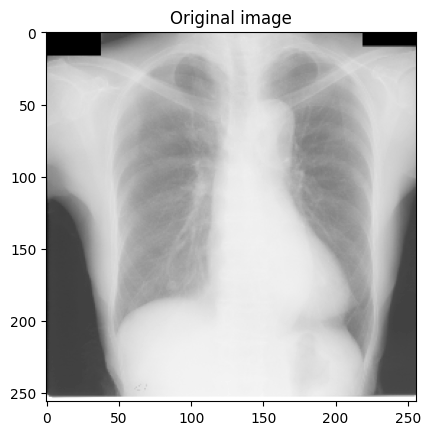

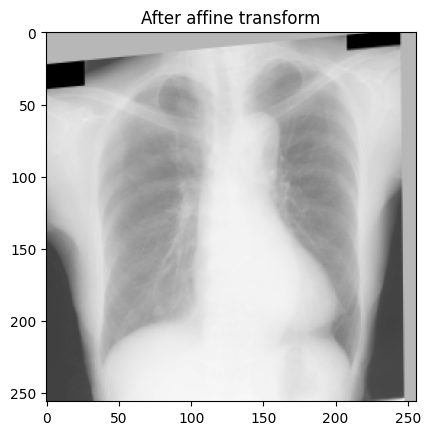

In [61]:
plt.imshow(test_img.squeeze(), cmap='gray')
plt.title('Original image')
plt.figure()
plt.imshow(augment_affine(test_img.unsqueeze(0), test_seg.unsqueeze(0))[0].squeeze().cpu(),cmap='gray')
plt.title('After affine transform')

## Loss weighting

The different organs in medical images are very different in size. It is therefore often necessary to weigh the loss with inverse frequency to improve the training stability. You can use `torch.bincount` ([pytorch-doc]([https://pytorch.org/docs/stable/generated/torch.bincount.html)) on a 1D vector (of long datatype) that you can obtain with `.reshape` from `train_dataset.seg_masks`. Convert the count into a float vector and use a reciprocal power of 0.35 to obtain a weight vector. Divide this vector by its mean - it should look as follows: `tensor([0.4031, 0.6409, 0.6934, 0.7888, 1.7354, 1.7383])`

In [20]:
segmentation_masks = train_dataset.seg_masks.reshape(-1) #Concatinating all pixel vectors into a 1D shape
class_count = torch.bincount(segmentation_masks.long()) #Count the classes frequency
class_count_float = class_count.float() #Converting them to float values
reciprocal_powered = torch.pow(class_count_float, -0.35) #Reciprocally powered vector by -0.35
weights = reciprocal_powered / torch.mean(reciprocal_powered) #Normalize the vector by its' mean
weights

tensor([0.4031, 0.6409, 0.6934, 0.7888, 1.7354, 1.7383])

## Simple convolutional network

Next, we build our fully-convolutional network `fullyconv` that directly predicts the probability of each class on a coarse grid and uses a simple upsampling to match the original resolution. Therefor, we need a `nn.Sequential` container that holds four ConvGroups. Each group consists of

1. a `nn.Conv2d` with kernel size = 3, padding = 1
2. a `nn.InstanceNorm2d` for normalisation
3. a `nn.LeakyReLU` as non-linearity

The first ConvGroup should increase the channel dimension to 16 and reduce the spatial dimension with a `stride=2` in the `nn.Conv2d`. The second group should double the channels and again reduce the spatial dimension using the same stride as group one. The third and fourth group have an output channel dimension=64 and keep the spatial resolution (no stride).

Finally, we use a single `nn.Conv2d` with same kernel and padding properties like the one of the ConvGroup as classifier. The output channel should match the number of classes=6.

The model should have $63,686$ trainable parameters.

In [32]:
# for reproducibility
torch.manual_seed(42)

#TODO implement backbone
fullyconv = nn.Sequential(
    #First Layer
    nn.Conv2d(in_channels = 1, out_channels = 16, stride = 2, kernel_size = 3, padding = 1),
    nn.InstanceNorm2d(num_features = 16),
    nn.LeakyReLU(),

    #Second Layer
    nn.Conv2d(in_channels = 16, out_channels = 32, stride = 2, kernel_size = 3, padding = 1),
    nn.InstanceNorm2d(num_features = 32),
    nn.LeakyReLU(),

    #Third Layer
    nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
    nn.InstanceNorm2d(num_features = 64),
    nn.LeakyReLU(),

    #Fourth Layer
    nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
    nn.InstanceNorm2d(num_features = 64),
    nn.LeakyReLU(),

    #Classifier (matching the input to output channels according to classes quantity)
    nn.Conv2d(in_channels = 64, out_channels = 6, kernel_size = 3, padding = 1)
)

summary(fullyconv, (1, 1, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 6, 64, 64]            --
├─Conv2d: 1-1                            [1, 16, 128, 128]         160
├─InstanceNorm2d: 1-2                    [1, 16, 128, 128]         --
├─LeakyReLU: 1-3                         [1, 16, 128, 128]         --
├─Conv2d: 1-4                            [1, 32, 64, 64]           4,640
├─InstanceNorm2d: 1-5                    [1, 32, 64, 64]           --
├─LeakyReLU: 1-6                         [1, 32, 64, 64]           --
├─Conv2d: 1-7                            [1, 64, 64, 64]           18,496
├─InstanceNorm2d: 1-8                    [1, 64, 64, 64]           --
├─LeakyReLU: 1-9                         [1, 64, 64, 64]           --
├─Conv2d: 1-10                           [1, 64, 64, 64]           36,928
├─InstanceNorm2d: 1-11                   [1, 64, 64, 64]           --
├─LeakyReLU: 1-12                        [1, 64, 64, 64]           --
├─C

## Training loop

Implement your training loop by completing the function `train_model` with the forward and backward pass, the update step on the optimizer and returns the loss history. Refer to [torch.optim](https://pytorch.org/docs/stable/optim.html#taking-an-optimization-step) to see an example of the training loop in pytorch.

Each training step will be on a batch of three images. Move the images and labels to the GPU and augment them with your augment_affine function. Make sure to upsample the prediction of your model to the correct output shape (same size as your target) using `F.interpolate` ([pytorch-doc](https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html)). Do not forget to pass the weight tensor to `nn.CrossEntropyLoss` ([pytorch-doc](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)).

In [34]:
train_dataloader = DataLoader(train_dataset, batch_size=3, shuffle=True, num_workers=2, drop_last=True)

In [59]:
# implement training loop
def train_model(model: nn.Module, num_epoch=50) -> torch.Tensor:
    # TODO: use Adam optimizer with a learning rate of 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    # TODO: use CrossEntropyLoss with pre-defined weighting
    weights = torch.tensor([0.4031, 0.6409, 0.6934, 0.7888, 1.7354, 1.7383]).to(device)
    criterion = nn.CrossEntropyLoss(weight = weights)

    loss_history = torch.zeros(num_epoch)

    for epoch in trange(num_epoch, unit='epoch', desc='training'):
        ### TRAINING ###
        # set model to training mode
        model.train()
        for x, y in train_dataloader:
            x = x.cuda(non_blocking=True)
            y = y.cuda(non_blocking=True)
            H, W = x.shape[-2:]
            # TODO: apply affine augmentation
            x, y = augment_affine(x,y)
            # Reset gradient of optimizer
            optimizer.zero_grad()
            # TODO: get prediction from the model
            y_hat = model(x)
            # TODO: interpolate prediction to original size
            y_hat = F.interpolate(y_hat, size = y.shape[-2:], mode='bilinear', align_corners=True)
            # TODO: Calculate loss
            loss = criterion(y_hat, y)
            # TODO: Back-propagation and optimizer step
            loss.backward()
            optimizer.step()


            loss_history[epoch] += loss.detach().item()
        loss_history[epoch] /= len(train_dataloader)

        ### VALIDATION ###
        if epoch % 5 == 4:
            model.eval()
            dice = torch.zeros(5)
            for x, y in val_dataset:
                x = x.cuda(non_blocking=True).unsqueeze(0)
                y = y.cuda(non_blocking=True)
                with torch.no_grad():
                    y_hat = model(x)
                    y_hat = F.interpolate(y_hat, size=(H, W), mode='bilinear', align_corners=True)
                    dice += dice_coeff(y_hat.argmax(1).squeeze(), y, 6)
            dice /= len(val_dataset)
            tqdm.write(f"{epoch} epoch: loss: {'%0.3f'%loss_history[epoch]}, Dice: {'%0.3f'%(100*dice.mean())}")

    return loss_history

In [60]:
run_loss_fullyconv = train_model(fullyconv.to('cuda'), num_epoch=50)

training:   0%|          | 0/50 [00:00<?, ?epoch/s]

4 epoch: loss: 0.190, Dice: 83.990
9 epoch: loss: 0.174, Dice: 84.723
14 epoch: loss: 0.168, Dice: 83.792
19 epoch: loss: 0.188, Dice: 83.680
24 epoch: loss: 0.142, Dice: 84.924
29 epoch: loss: 0.151, Dice: 86.382
34 epoch: loss: 0.149, Dice: 85.211
39 epoch: loss: 0.127, Dice: 86.647
44 epoch: loss: 0.136, Dice: 87.337
49 epoch: loss: 0.130, Dice: 86.488


After 50 epochs, we can achieve an evaluation Dice of about 85\%. We have provided the following function to visualise the results on an unseen validation case.


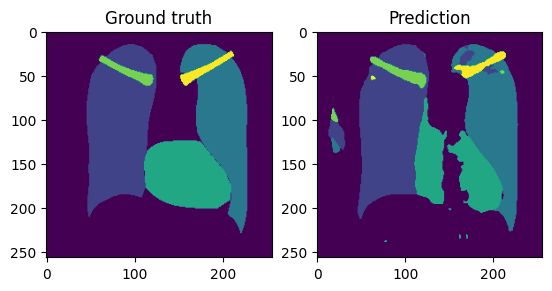

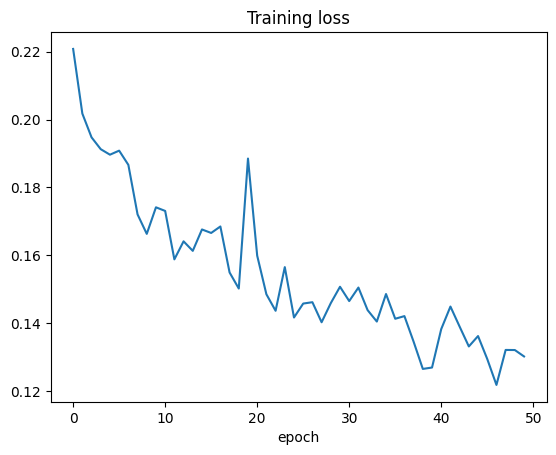

In [62]:
test_img, test_seg = val_dataset[2]
def show_results(model, run_loss):
    output=model(test_img.cuda().unsqueeze(0))
    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)
    ax1.imshow(test_seg)
    ax1.title.set_text('Ground truth')
    ax2.imshow(F.interpolate(output, size=(256,256), mode='bilinear').argmax(1).cpu().squeeze())
    ax2.title.set_text('Prediction')
    plt.figure()
    plt.plot(run_loss)
    plt.title('Training loss')
    plt.xlabel('epoch')

show_results(fullyconv, run_loss_fullyconv)

#Improving the model

The model's performance can be improved by extending the size of the fully convolutional network. Instead of output dimensions 16, 32 and 64 use the 64, 128 and 256.

The model should have $973,574$ trainable parameters

In [63]:
#TODO implement backbone
fullyconv2 = nn.Sequential(
    #First Layer
    nn.Conv2d(in_channels = 1, out_channels = 64, stride = 2, kernel_size = 3, padding = 1),
    nn.InstanceNorm2d(num_features = 16),
    nn.LeakyReLU(),

    #Second Layer
    nn.Conv2d(in_channels = 64, out_channels = 128, stride = 2, kernel_size = 3, padding = 1),
    nn.InstanceNorm2d(num_features = 32),
    nn.LeakyReLU(),

    #Third Layer
    nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1),
    nn.InstanceNorm2d(num_features = 64),
    nn.LeakyReLU(),

    #Fourth Layer
    nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
    nn.InstanceNorm2d(num_features = 64),
    nn.LeakyReLU(),

    #Classifier (matching the input to output channels according to classes quantity)
    nn.Conv2d(in_channels = 256, out_channels = 6, kernel_size = 3, padding = 1)
)
summary(fullyconv2, (1, 1, 256, 256))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 6, 64, 64]            --
├─Conv2d: 1-1                            [1, 64, 128, 128]         640
├─InstanceNorm2d: 1-2                    [1, 64, 128, 128]         --
├─LeakyReLU: 1-3                         [1, 64, 128, 128]         --
├─Conv2d: 1-4                            [1, 128, 64, 64]          73,856
├─InstanceNorm2d: 1-5                    [1, 128, 64, 64]          --
├─LeakyReLU: 1-6                         [1, 128, 64, 64]          --
├─Conv2d: 1-7                            [1, 256, 64, 64]          295,168
├─InstanceNorm2d: 1-8                    [1, 256, 64, 64]          --
├─LeakyReLU: 1-9                         [1, 256, 64, 64]          --
├─Conv2d: 1-10                           [1, 256, 64, 64]          590,080
├─InstanceNorm2d: 1-11                   [1, 256, 64, 64]          --
├─LeakyReLU: 1-12                        [1, 256, 64, 64]          --


In [64]:
run_loss_fullyconv2 = train_model(fullyconv2.to('cuda'), num_epoch=50)

training:   0%|          | 0/50 [00:00<?, ?epoch/s]

4 epoch: loss: 0.294, Dice: 73.541
9 epoch: loss: 0.190, Dice: 84.073
14 epoch: loss: 0.160, Dice: 86.473
19 epoch: loss: 0.151, Dice: 83.987
24 epoch: loss: 0.144, Dice: 87.411
29 epoch: loss: 0.122, Dice: 89.265
34 epoch: loss: 0.121, Dice: 89.568
39 epoch: loss: 0.179, Dice: 82.712
44 epoch: loss: 0.110, Dice: 90.401
49 epoch: loss: 0.119, Dice: 88.131


After 50 epochs, we can achieve an evaluation Dice of about 88\%.

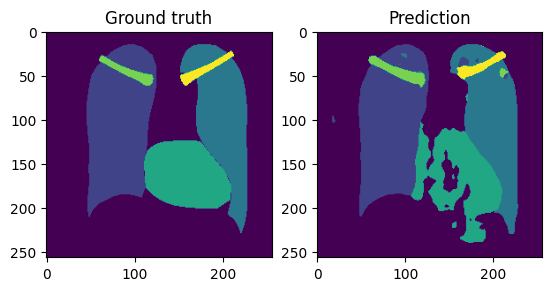

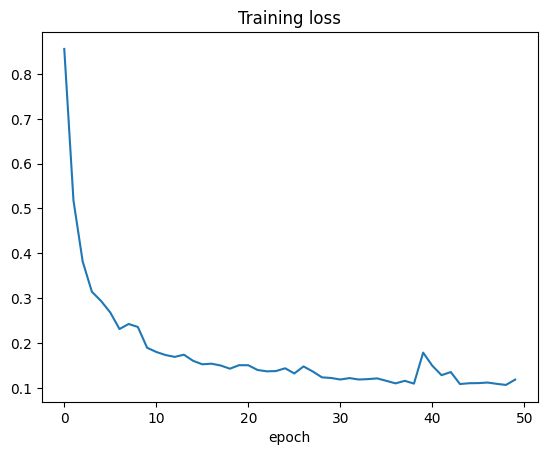

In [65]:
show_results(fullyconv2, run_loss_fullyconv2)

## U-Net

More elaborate network architecture usually surpass the performance of simple CNNs.

Probably the most popular architecture for segmentation is the [U-Net](https://arxiv.org/abs/1505.04597). It comprises an encoder, decoder and skip connections inbetween. The architecture is well explained [here](https://paperswithcode.com/method/u-net) or [here](https://medium.datadriveninvestor.com/an-overview-on-u-net-architecture-d6caabf7caa4).

For this task, implement a light-weight version of the U-Net with the following specifications:
- 4 encoding blocks
  - Block 1: $3 \times 3$ convolutions with 64 output channels, `padding=1`,`stride=1`, followed by an instance-normalization and a LeakyReLu activation.
  - Block 2-4: $3 \times 3$ convolutions with 128, 256 and 512 output channels respectively, `padding=1`,`stride=2`, followed by an instance-normalization and a LeakyReLu activation.
- 3 decoding blocks:
 - Block 4-2: $3 \times 3$ convolutions with 256, 128 and 64 output channels respectively, `padding=1`,`stride=1`, followed by an instance-normalization and a LeakyReLu activation.
 - The inputs to these blocks are the concatenation of 1) the output of the corresponding encoding block and 2) the output of the previous decoding block
- a classifier block
  - $1 x 1$ convolutions, number of output channels correspond to the number of classes


The model should have $3,873,094$ trainable parameters. The training for this network takes longer than for the simple CNN.

In [69]:
class LightUNet(nn.Module):
    def __init__(self, num_classes: int, num_input_channel: int = 1):
        super().__init__()
        self.encoder_block1 = nn.Sequential(
            nn.Conv2d(num_input_channel, 64, 3, padding=1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU()
        )
        # TODO: Encoder blocks 2-4
        self.encoder_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size = 3, padding = 1, stride = 2),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU()
        )
        self.encoder_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size = 3, padding = 1, stride = 2),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU()
        )

        self.encoder_block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size = 3, padding = 1, stride = 2),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU()
        )


        self.decoder_block4 = nn.Sequential(
            nn.Conv2d(512 + 256, 256, 3, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU()
        )
        # TODO: Decoder blocks 3-2
        self.decoder_block3 = nn.Sequential(
            nn.Conv2d(256 + 128, 128, kernel_size = 3, padding = 1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU()
        )

        self.decoder_block2 = nn.Sequential(
            nn.Conv2d(128 + 64, 64, kernel_size = 3, padding = 1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU()
        )
        # TODO: classifier
        self.classifier = nn.Conv2d(64, num_classes, kernel_size = 1)

    def upscale_concat(self, from_skipconnection, from_decoder):
        # upscale last decoder output and concatenate with encoder output
        from_decoder_upscaled = F.interpolate(from_decoder, scale_factor=2, mode='bilinear')
        x = torch.cat((from_decoder_upscaled, from_skipconnection), dim=1)
        return x

    def forward(self, x):
        # encoder
        x1 = self.encoder_block1(x)
        x2 = self.encoder_block2(x1)
        # TODO: forward pass for encoder block 3 and 4
        x3 = self.encoder_block3(x2)
        x4 = self.encoder_block4(x3)

        # decoder
        x = self.decoder_block4(self.upscale_concat(x3, x4))
        x = self.decoder_block3(self.upscale_concat(x2, x))
        # TODO: forward pass for decoder block 2
        x = self.decoder_block2(self.upscale_concat(x1, x))
        x = self.classifier(x)
        return x
unet = LightUNet(num_classes=6)
unet.to('cuda')
summary(unet, (1, 1, 256, 192))

Layer (type:depth-idx)                   Output Shape              Param #
LightUNet                                [1, 6, 256, 192]          --
├─Sequential: 1-1                        [1, 64, 256, 192]         --
│    └─Conv2d: 2-1                       [1, 64, 256, 192]         640
│    └─InstanceNorm2d: 2-2               [1, 64, 256, 192]         --
│    └─LeakyReLU: 2-3                    [1, 64, 256, 192]         --
├─Sequential: 1-2                        [1, 128, 128, 96]         --
│    └─Conv2d: 2-4                       [1, 128, 128, 96]         73,856
│    └─InstanceNorm2d: 2-5               [1, 128, 128, 96]         --
│    └─LeakyReLU: 2-6                    [1, 128, 128, 96]         --
├─Sequential: 1-3                        [1, 256, 64, 48]          --
│    └─Conv2d: 2-7                       [1, 256, 64, 48]          295,168
│    └─InstanceNorm2d: 2-8               [1, 256, 64, 48]          --
│    └─LeakyReLU: 2-9                    [1, 256, 64, 48]          --
├─Seq

In [70]:
run_loss_unet = train_model(unet.to('cuda'), num_epoch=50)

training:   0%|          | 0/50 [00:00<?, ?epoch/s]

4 epoch: loss: 0.298, Dice: 78.502
9 epoch: loss: 0.185, Dice: 81.299
14 epoch: loss: 0.155, Dice: 88.021
19 epoch: loss: 0.135, Dice: 87.921
24 epoch: loss: 0.132, Dice: 89.310
29 epoch: loss: 0.109, Dice: 90.476
34 epoch: loss: 0.094, Dice: 91.490
39 epoch: loss: 0.112, Dice: 90.536
44 epoch: loss: 0.090, Dice: 89.604
49 epoch: loss: 0.093, Dice: 91.553


After 50 epochs, we can achieve an evaluation Dice of about 92\%.

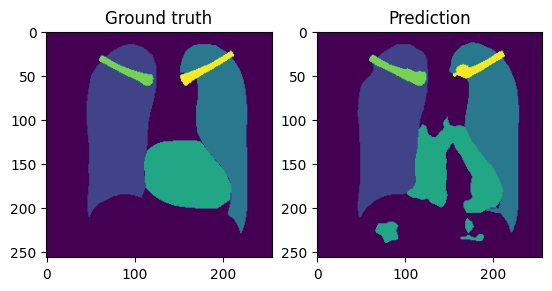

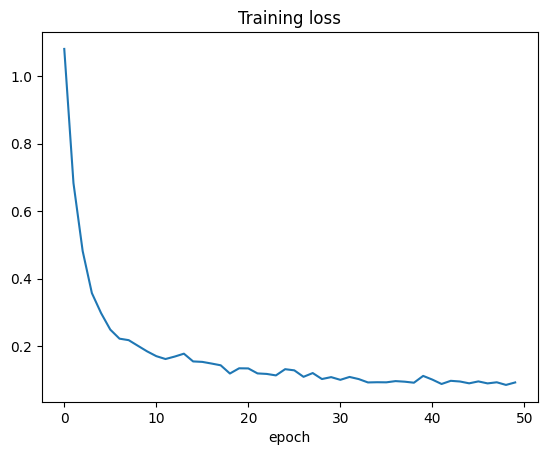

In [71]:
show_results(unet, run_loss_unet)